In [2]:
#importing important libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import re,nltk,string
import itertools
import seaborn as sns
from string import punctuation
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, Embedding, Input,LSTM,Bidirectional,GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")

2023-05-10 14:43:36.369220: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-10 14:43:36.407110: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 14:43:37.263171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 14:43:37.268220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 14:43:39.796663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
#reading the two dataset
true=pd.read_csv("True.csv")
fake=pd.read_csv("Fake.csv")

In [4]:
#dropping subject and date column from both the dataset
true=true.drop(['subject','date'],axis=1)
fake=fake.drop(['subject','date'],axis=1)

In [5]:
#Adding label column to both the dataset
fake['label']='Fake'
true['label']='True'

In [6]:
#concatenating both the datset and shufling it randomly 
df=pd.concat([true,fake],ignore_index=True)
df = df.sample(frac = 1)

In [8]:
df.shape

(44898, 3)

In [161]:
df.head()

,title,text,label
26189,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",Fake
36470,GREAT NEWS! House GOP Moderates Threaten “You ...,It looks like there is more than one good reas...,Fake
42370,WATCH: Shocking Number Of Swedish Citizens WAL...,"During the Democrats first debate last month,...",Fake
4275,Trump asks government agencies for plans to cu...,"WASHINGTON (Reuters) - President Donald Trump,...",True
42078,MILLENNIAL Drops Awesome TRUTH BOMB On Her Gen...,One millennial is 100% FED Up! with her genera...,Fake


In [162]:
#Removing news source info from text using regular expression

def extract_txt(text):
    regex=re.search(r"(?<=\(Reuters\)\s\-\s).*",text)
    if regex:
        return regex.group(0)
    return text
df['text_preprocessed']=df['text'].apply(extract_txt)

In [163]:
#label encoding the label column i.e True is mapped to 0 and False to 1
df["label"] = df.label.apply(lambda  x:0 if x=='True' else 1)
df.head()

,title,text,label,text_preprocessed
26189,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"You know, because in fantasyland Republicans n..."
36470,GREAT NEWS! House GOP Moderates Threaten “You ...,It looks like there is more than one good reas...,1,It looks like there is more than one good reas...
42370,WATCH: Shocking Number Of Swedish Citizens WAL...,"During the Democrats first debate last month,...",1,"During the Democrats first debate last month,..."
4275,Trump asks government agencies for plans to cu...,"WASHINGTON (Reuters) - President Donald Trump,...",0,"President Donald Trump, who has proposed cuts ..."
42078,MILLENNIAL Drops Awesome TRUTH BOMB On Her Gen...,One millennial is 100% FED Up! with her genera...,1,One millennial is 100% FED Up! with her genera...


In [164]:
#combining text_preprocessed and title for crearing full news article with headline
df['final_news']=df['title']+" "+df['text_preprocessed']
df.head()

,title,text,label,text_preprocessed,final_news
26189,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"You know, because in fantasyland Republicans n...",WATCH: Giuliani Demands That Democrats Apolog...
36470,GREAT NEWS! House GOP Moderates Threaten “You ...,It looks like there is more than one good reas...,1,It looks like there is more than one good reas...,GREAT NEWS! House GOP Moderates Threaten “You ...
42370,WATCH: Shocking Number Of Swedish Citizens WAL...,"During the Democrats first debate last month,...",1,"During the Democrats first debate last month,...",WATCH: Shocking Number Of Swedish Citizens WAL...
4275,Trump asks government agencies for plans to cu...,"WASHINGTON (Reuters) - President Donald Trump,...",0,"President Donald Trump, who has proposed cuts ...",Trump asks government agencies for plans to cu...
42078,MILLENNIAL Drops Awesome TRUTH BOMB On Her Gen...,One millennial is 100% FED Up! with her genera...,1,One millennial is 100% FED Up! with her genera...,MILLENNIAL Drops Awesome TRUTH BOMB On Her Gen...


In [165]:
#droping the dataset not be used
df=df.drop(['title','text','text_preprocessed'],axis=1)

In [166]:
df.head()

,label,final_news
26189,1,WATCH: Giuliani Demands That Democrats Apolog...
36470,1,GREAT NEWS! House GOP Moderates Threaten “You ...
42370,1,WATCH: Shocking Number Of Swedish Citizens WAL...
4275,0,Trump asks government agencies for plans to cu...
42078,1,MILLENNIAL Drops Awesome TRUTH BOMB On Her Gen...


In [167]:
#creating list of possible stopwords from nltk library
stop = stopwords.words('english')
#Defining function for text cleaning
def text_clean(text):
    #Lower Letters
    words=text.lower().split()
    #remove stop words 
    txt=' '.join([w for w in words if not w in (stop)])
    # removing non-alphabetic characters
    txt = re.sub('[^a-z]',' ',txt)
    return txt  

In [168]:
df['final_news']=df.final_news.apply(text_clean)

In [169]:
df.head()

,label,final_news
26189,1,watch giuliani demands democrats apologize tr...
36470,1,great news house gop moderates threaten you ...
42370,1,watch shocking number swedish citizens walk g...
4275,0,trump asks government agencies plans cut spend...
42078,1,millennial drops awesome truth bomb generation...


In [170]:
path='/home/prabhat-ubuntu/Downloads' ##path where the text file for glove is present

EMBEDDING_FILE=f'{path}/glove.6B.50d.txt'##used glove for word embedding 

# configuration setting
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 10

In [171]:
y = df['label'].values
X = df.drop(['label'],axis=1)

In [172]:
y.shape

(44898,)

In [173]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(EMBEDDING_FILE) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32') #for word we are creating an array 
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [174]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(list(X['final_news']))
X = tokenizer.texts_to_sequences(list(X['final_news']))

# pad sequences so that we get a N x T matrix
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (44898, 100)


In [175]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 115831 unique tokens.


In [176]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [177]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [178]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

Building model...


2023-05-10 03:50:28.525071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 03:50:28.530940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 03:50:28.534084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 100, 50)           1000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 30)          7920      
 nal)                                                            
                                                                 
 global_max_pooling1d_4 (Glo  (None, 30)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,007,951
Trainable params: 7,951
Non-trainab

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y, random_state=0)

In [180]:
print('Training model...')
r = model.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Training model...
Epoch 1/10


2023-05-10 03:51:29.170341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 03:51:29.177277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 03:51:29.179985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

898/898 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9087

2023-05-10 03:52:29.213830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 03:52:29.216827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 03:52:29.218203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

898/898 [==============================] - 64s 62ms/step - loss: 0.2352 - accuracy: 0.9087 - val_loss: 0.1418 - val_accuracy: 0.9456
Epoch 2/10
898/898 [==============================] - 49s 55ms/step - loss: 0.1191 - accuracy: 0.9554 - val_loss: 0.1126 - val_accuracy: 0.9581
Epoch 3/10
898/898 [==============================] - 57s 64ms/step - loss: 0.0942 - accuracy: 0.9658 - val_loss: 0.0986 - val_accuracy: 0.9639
Epoch 4/10
898/898 [==============================] - 58s 64ms/step - loss: 0.0883 - accuracy: 0.9694 - val_loss: 0.0940 - val_accuracy: 0.9658
Epoch 5/10
898/898 [==============================] - 54s 60ms/step - loss: 0.0716 - accuracy: 0.9749 - val_loss: 0.0823 - val_accuracy: 0.9717
Epoch 6/10
898/898 [==============================] - 81s 90ms/step - loss: 0.0593 - accuracy: 0.9789 - val_loss: 0.0689 - val_accuracy: 0.9758
Epoch 7/10
898/898 [==============================] - 44s 49ms/step - loss: 0.0543 - accuracy: 0.9815 - val_loss: 0.0667 - val_accuracy: 0.9776
Epo

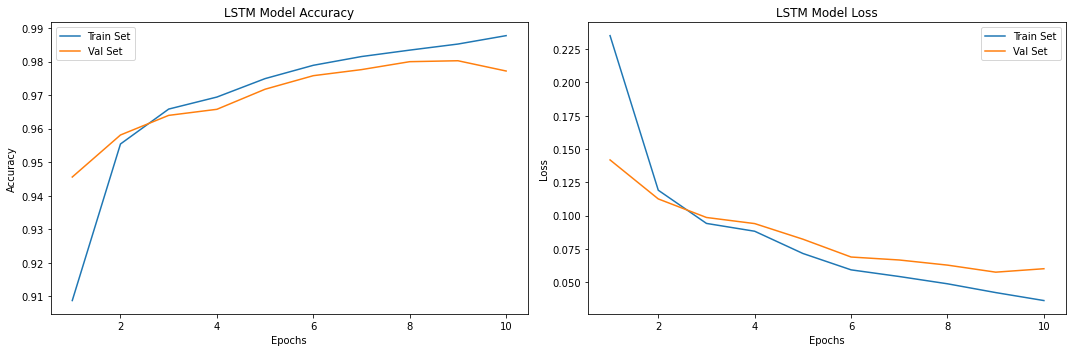

In [181]:
acc = r.history['accuracy']##retrieves the training accuracy values stored in the 'accuracy' key of the dictionary.
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs_range = range(1, len(r.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss')

plt.tight_layout()
plt.show()

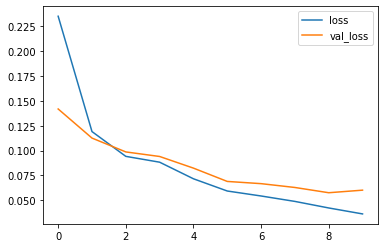

In [182]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

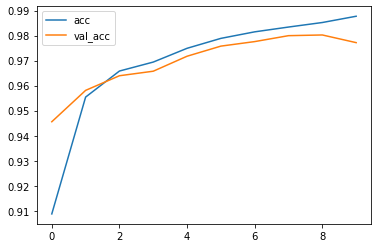

In [183]:
# Plotting accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [184]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

1123/1123 [==============================] - 15s 14ms/step - loss: 0.0375 - accuracy: 0.9873
Accuracy of the model on Training Data is -  98.73043894767761
281/281 [==============================] - 4s 13ms/step - loss: 0.0568 - accuracy: 0.9802
Accuracy of the model on Testing Data is -  98.017817735672


In [185]:
pred = model.predict(X_test)
pred[:5]

2023-05-10 04:02:06.079840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 04:02:06.083873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 04:02:06.085838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

281/281 [==============================] - 5s 14ms/step


array([[0.9591257 ],
       [0.00105776],
       [0.9747504 ],
       [0.9996298 ],
       [0.9999413 ]], dtype=float32)

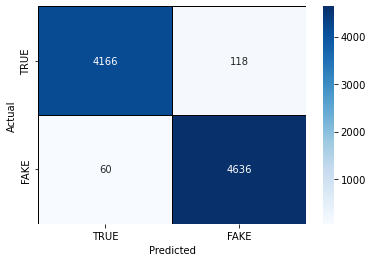

In [186]:
cm = confusion_matrix(y_test,pred.round())
cm = pd.DataFrame(cm , index = ['TRUE','FAKE'] , columns = ['TRUE','FAKE'])
plt.figure(figsize = (6,4))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['TRUE','FAKE'] , yticklabels = ['TRUE','FAKE'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [187]:
print(classification_report(y_test,pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4284
           1       0.98      0.99      0.98      4696

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [188]:
y_pred = model.predict(X_test).ravel()

281/281 [==============================] - 5s 18ms/step


In [219]:
testSent =[" The meeting between Kumar and Patnaik lasted for an hour and a half. Patnaik downplayed the political buzz around the meeting, saying he and Kumar are old friends and colleagues who worked together in the Atal Bihari Vajpayee-led government and that no discussions were held on a possible alliance.",
       "Foxconn, a major Apple supplier, announced in a filing on Tuesday that it has purchased a large plot of land in the outskirts of Bengaluru, the Indian IT hub, as part of its efforts to diversify away from China as its primary place of production."]

In [220]:
def cleanText(txt):
    txt = txt.lower()
    txt = ' '.join([word for word in txt.split() if word not in (stop)])
    txt = re.sub('[^a-z]',' ',txt)
    return txt 

In [221]:
def predict_text(lst_text):
    test = tokenizer.texts_to_sequences(lst_text)
    # pad sequences so that we get a N x T matrix
    testX = pad_sequences(test, maxlen=MAX_SEQUENCE_LENGTH)
    df_test = pd.DataFrame(lst_text, columns = ['test_sent'])

    prediction = model.predict(testX)
    df_test['prediction']=prediction
    df_test["test_sent"] = df_test["test_sent"].apply(cleanText)
    df_test['prediction']=df_test['prediction'].apply(lambda x: "Fake" if x>=0.5 else "Real")
    return df_test

In [222]:
df_testsent = predict_text(testSent)
df_testsent

1/1 [==============================] - 0s 185ms/step


,test_sent,prediction
0,meeting kumar patnaik lasted hour half patnai...,Real
1,foxconn major apple supplier announced filin...,Real
